# Step 4: Model Exploration and Optimization

In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns

#image and output formatting
import PIL
from PIL import Image
from tabulate import tabulate

#dir manip libraries
import os, sys, glob, pathlib, tempfile
from pathlib import Path

#import label encoding
from sklearn.preprocessing import LabelEncoder

#keras for model output customization
import keras
from keras import layers, ops

#tensorflow tools for model building
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling, Activation, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Sklearn tools for SVM model building
from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Custom functions (this works, finally)
from pyTools.utils import *
from pyTools.preprocess import *
from pyTools.predict import *

# Print out versions for important tools
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Pillow version:", PIL.__version__)

Pandas version: 2.1.4
TensorFlow version: 2.16.1
Pillow version: 10.2.0


In [2]:
# Define the path to your Google Drive folder containing the images
data_dir = Path("../ML_Asm2_ProjFiles/classify_by_shape")

In [3]:
data = data_from_dir(data_dir)

Found 19860 files belonging to 5 classes.


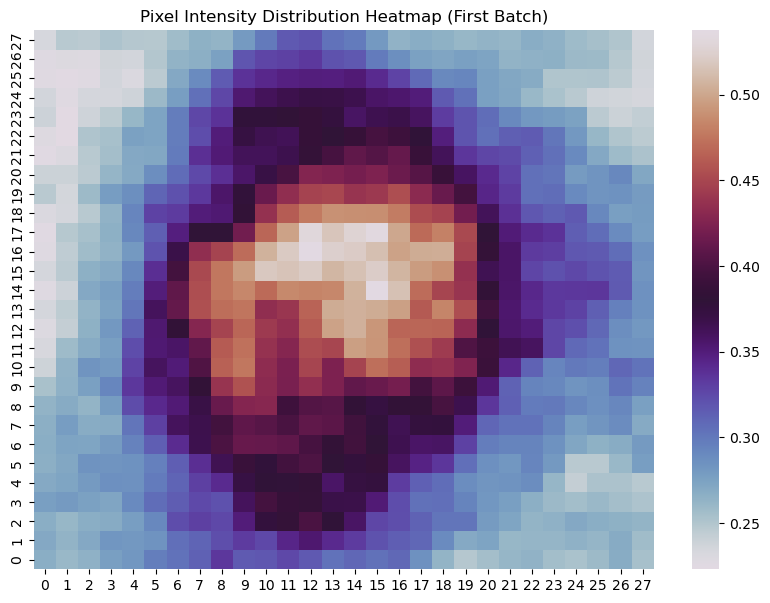

In [4]:
first_batch = next(iter(data))
images, labels = first_batch
images = images / 255.0
pixel_sum = np.zeros((img_height, img_width), dtype=float)

for img in images:
    pixel_sum += img.numpy().squeeze()  # .squeeze() to remove single-channel dimension
    
pixel_mean = pixel_sum / images.shape[0]
plt.figure(figsize=(10, 7))
sns.heatmap(pixel_mean, cmap='twilight') #viridis also looks good
plt.gca().invert_yaxis()  # This line reverses the y-axis direction
plt.title('Pixel Intensity Distribution Heatmap (First Batch)')
plt.show()

In [5]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [6]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

***compile()***:
  - ***optimizer***: Stochastic Gradient Descent, **Adoptive Moment Estimator(Adam)**
  - ***loss***: **Categorical (Focal) Cross Entropy**
  - ***metrics***: **(Categorical) Accuracy**, Top K Categorical, Categorical Cross Entropy, F1/Precision/Recall, AUC, IoU, MeanIoU

Initial design for baseline model.
Our goal was to design a simple Multilayer Perceptron baseline that utilizes keras libraries and utilities. Partially because of keras's versatility as a highly customisable tool, this model poses as a milestone for us to implement different modifications and tunings in development in the next steps.

In [7]:
external_dir = "../ML_Asm2_ProjFiles/Test"  # Path to your dataset
raw_data = []

# Loop through all image files in the specified directory
for img_file in os.listdir(external_dir):
    if img_file.endswith((".png", ".jpg", ".jpeg", ".bmp")):
        # Get the full path to the image
        img_path = os.path.join(external_dir, img_file)
        
        # Preprocess the image using the defined function
        preprocessed_img = preprocess28(img_path)
        
        # Add the preprocessed image to the raw_data list
        raw_data.append(preprocessed_img)

# Shuffle the images to randomize the order
random.shuffle(raw_data)

# Convert the list to a NumPy array
raw_data = np.array(raw_data)

# Notes: 
    Baseline model: 
     - Strength: 
     1. Classify data in the same dataset with very high accuracy. 
     2. Not computationally expensive
     
     - Weakness: 
     1. Inconsistent output metrics in each epoch. 
     2. Poor classification for external data
        -> Cause: Overfitting, Rudimentary Model. 

    Conclusion: Although the model did not perform well on external data, it reached a certain degree of generalization, which is fairly enough for this stage. 

In [8]:
model_1 = Sequential([ #Enhanced CNN with more diverse architecture and regularization
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_2 = Sequential([ #Enhanced CNN with more diverse architecture and regularization
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)), 
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_3 = Sequential([ #CNN with Batch Normalization and varied architecture
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_4 = Sequential([ #Deep Neural Network (notable design dif: (2 Conv layer -> Pooling)*3
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(216, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_5 = Sequential([ #Deep Neural Network (notable design dif: (2 Conv layer -> Pooling)*3
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(216, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_6 = Sequential([ #CNN inspired from InceptionNet with varied architecture
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(1, 1), activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

model_7 = Sequential([ #CNN inspired from InceptionNet with BatchNorm and Maxpooling
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(1, 1), activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])


NeuralNetwork_models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,788,805 (98.38 MB)

 Trainable params: 25,788,805 (98.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - loss: 1.5592 - sparse_categorical_accuracy: 0.2457 - val_loss: 1.3588 - val_sparse_categorical_accuracy: 0.5218
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - loss: 1.2944 - sparse_categorical_accuracy: 0.5414 - val_loss: 1.0452 - val_sparse_categorical_accuracy: 0.7108
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - loss: 1.0120 - sparse_categorical_accuracy: 0.7357 - val_loss: 0.7920 - val_sparse_categorical_accuracy: 0.8231
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - loss: 0.7853 - sparse_categorical_accuracy: 0.8039 - val_loss: 0.6191 - val_sparse_categorical_accuracy: 0.8428
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - loss: 0.6512 - sparse_categorical_accuracy: 0.8268 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.8492
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.4892 - val_sparse_categorical_acc

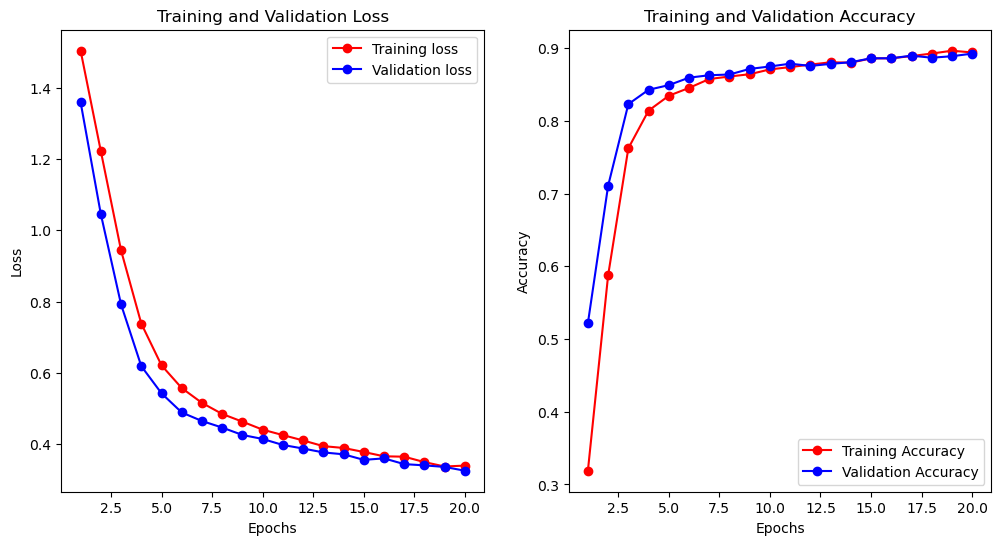

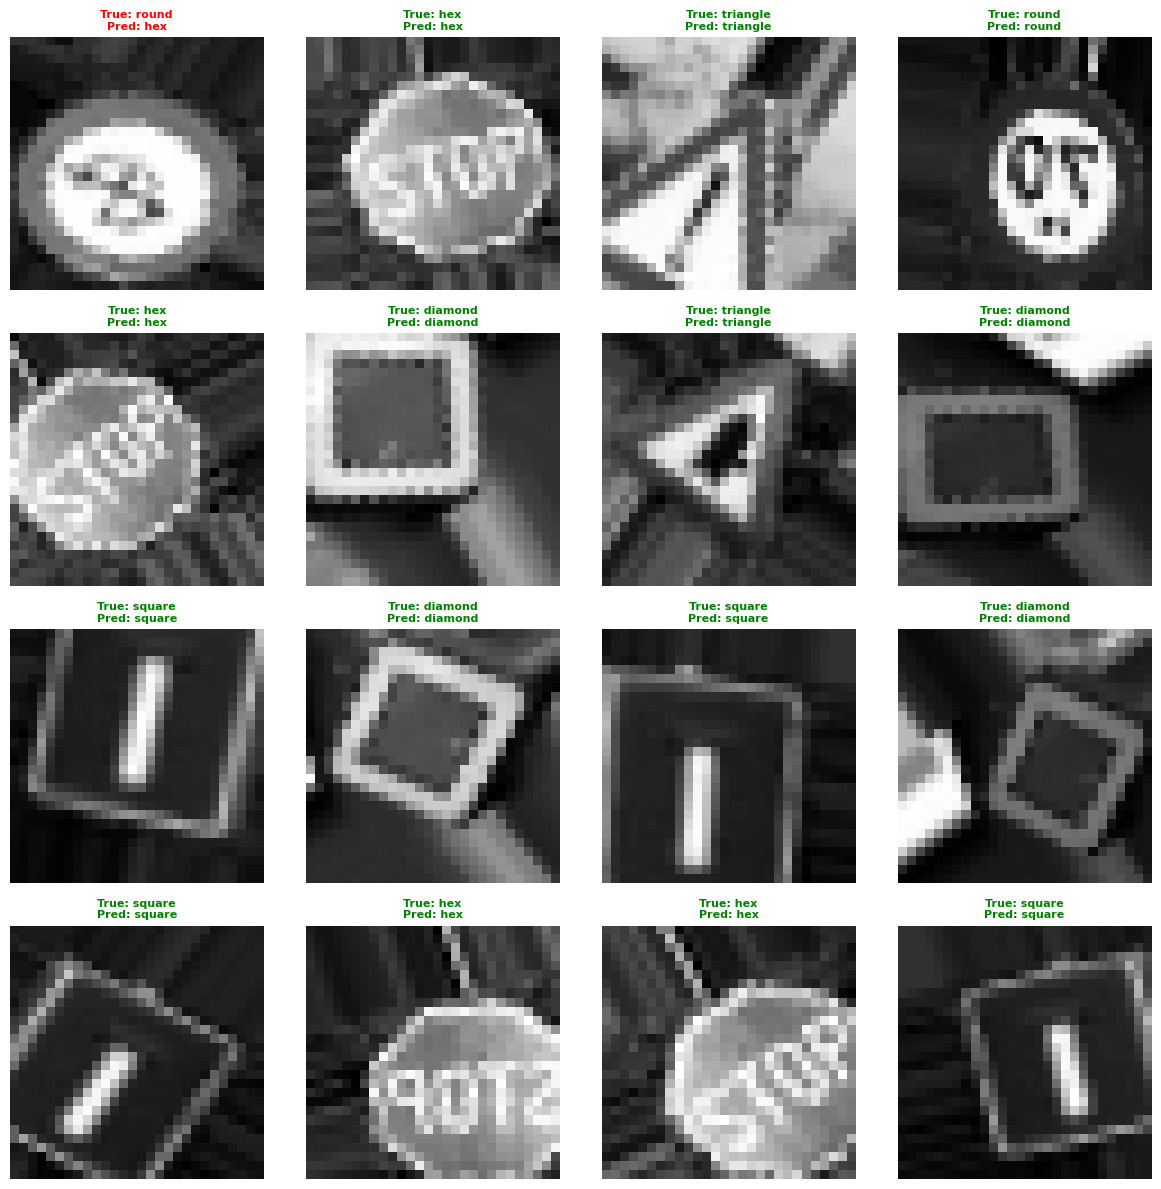

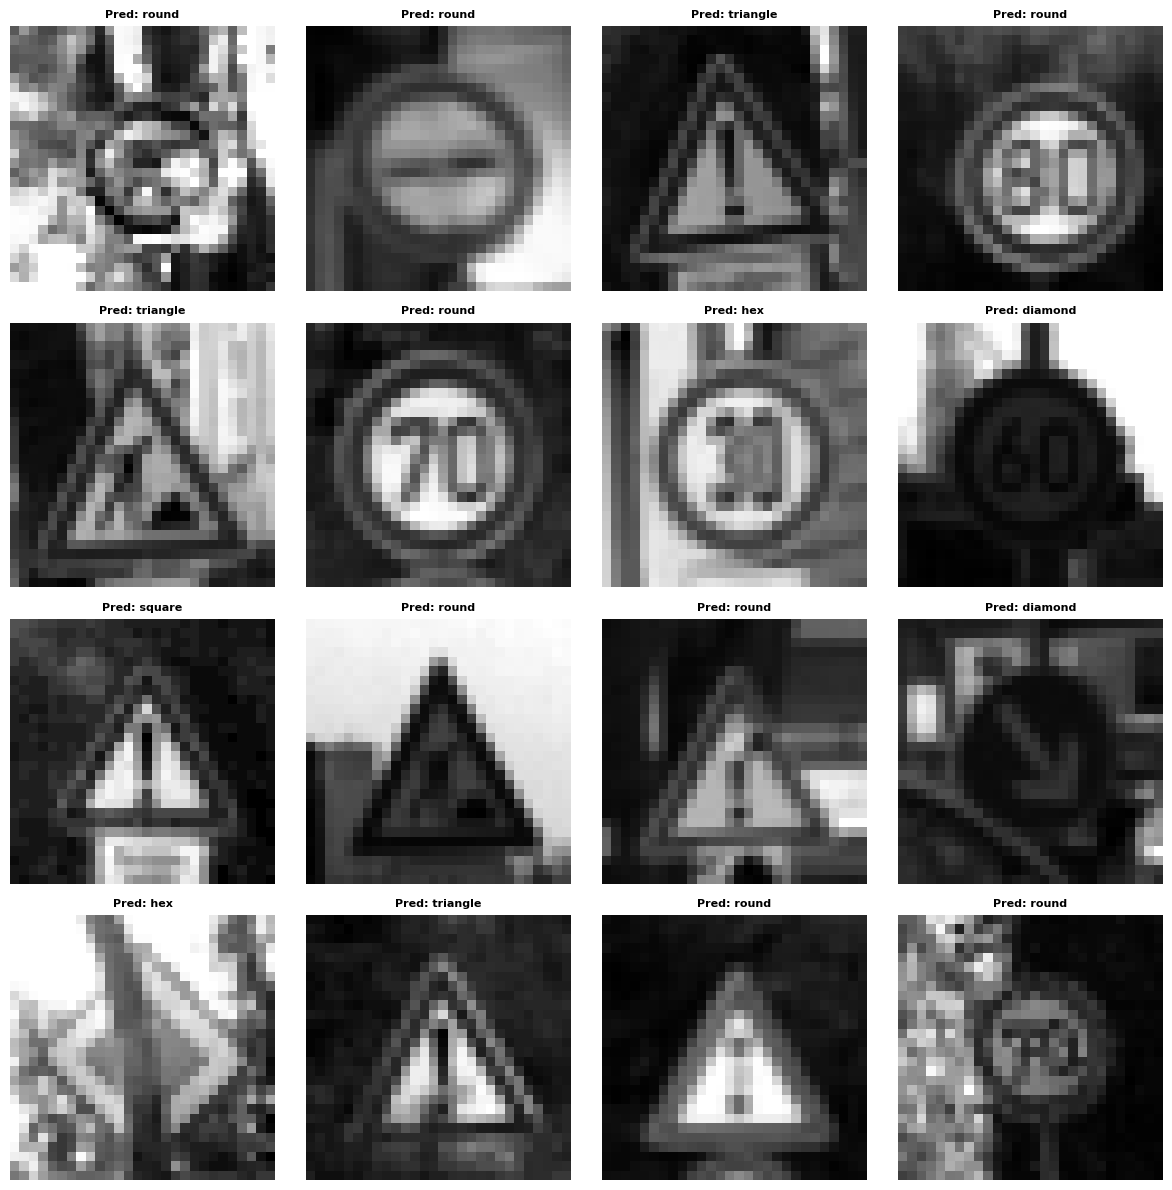

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,461 (513.52 KB)

 Trainable params: 131,461 (513.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 1.6127 - sparse_categorical_accuracy: 0.2034 - val_loss: 1.6005 - val_sparse_categorical_accuracy: 0.2256
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.5999 - sparse_categorical_accuracy: 0.2352 - val_loss: 1.5890 - val_sparse_categorical_accuracy: 0.2869
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 1.5869 - sparse_categorical_accuracy: 0.2829 - val_loss: 1.5747 - val_sparse_categorical_accuracy: 0.3295
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.5706 - sparse_categorical_accuracy: 0.3443 - val_loss: 1.5556 - val_sparse_categorical_accuracy: 0.3962
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.5498 - sparse_categorical_accuracy: 0.3783 - val_loss: 1.5291 - val_sparse_categorical_accuracy: 0.4659
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.5241 - sparse_categorical_accuracy: 0.4208 - val_loss: 1.4971 - val_sparse_categorical_accuracy: 0.561

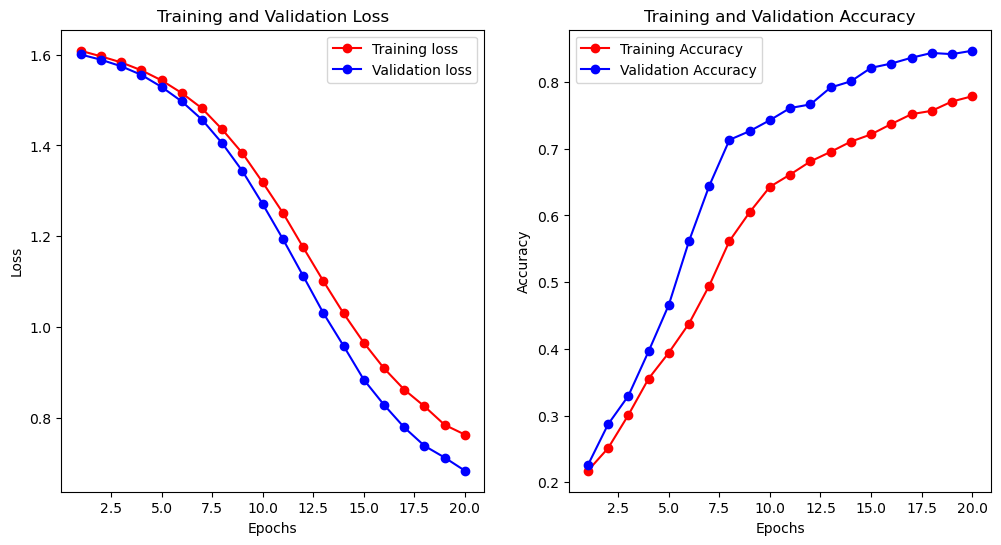

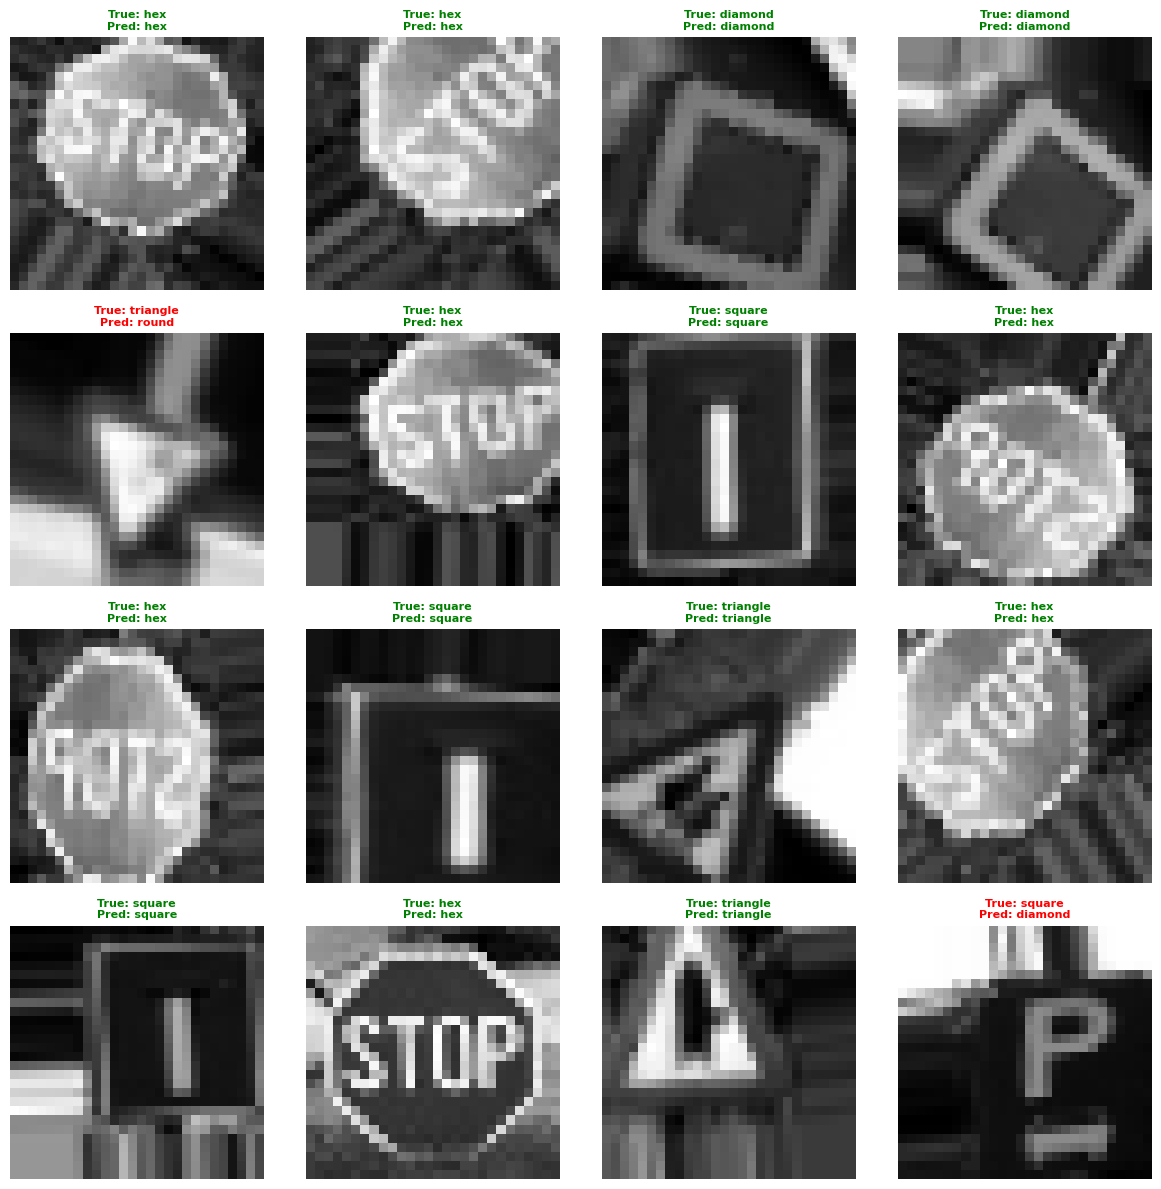

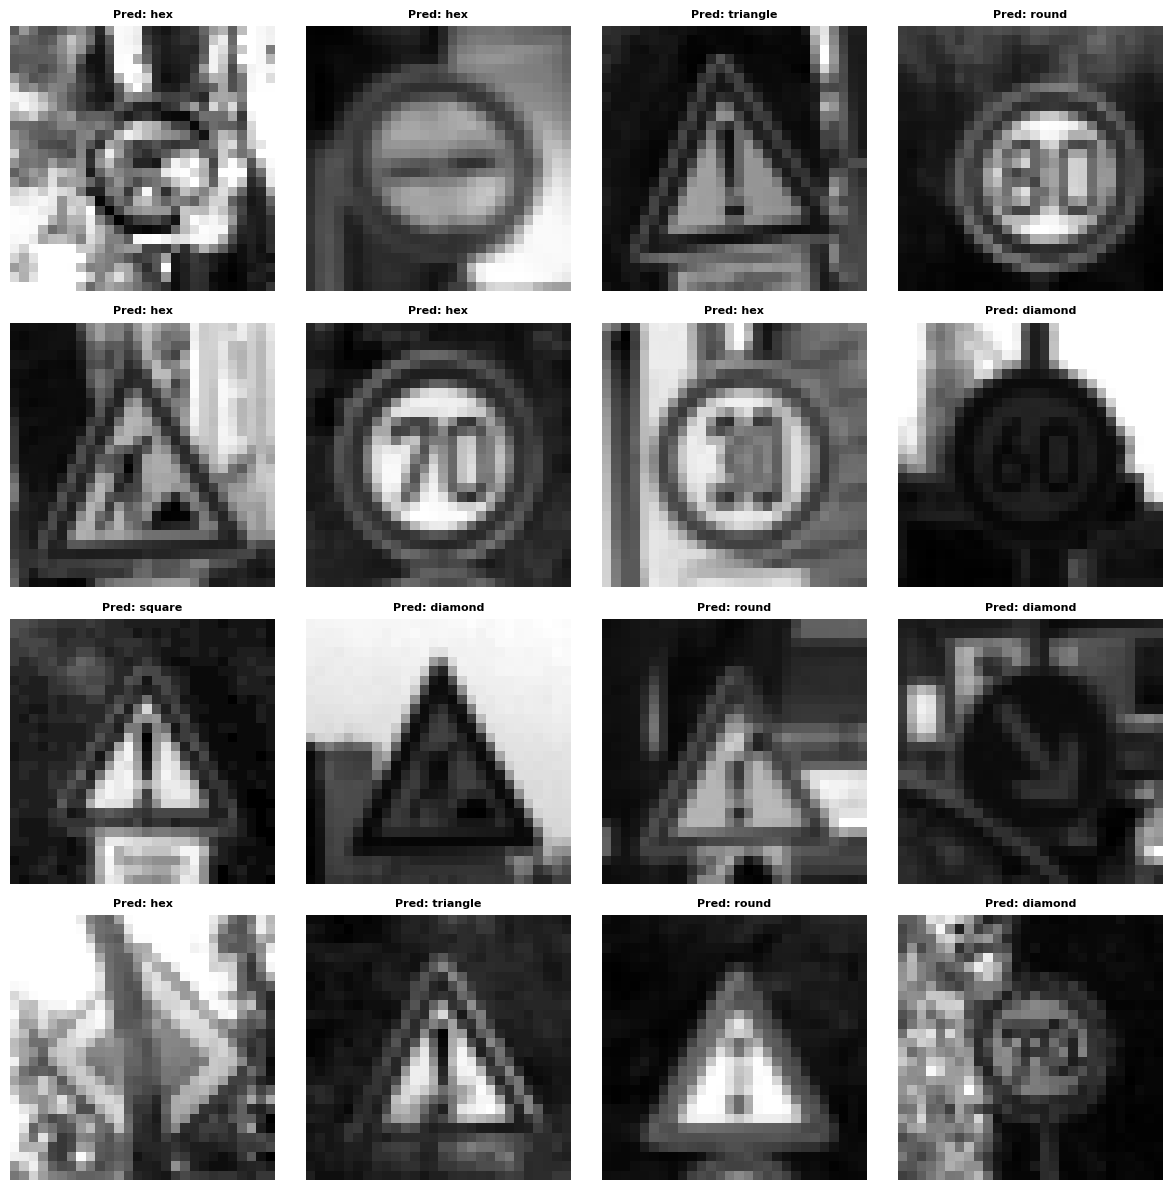

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,741 (674.77 KB)

 Trainable params: 172,517 (673.89 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 2.8756 - sparse_categorical_accuracy: 0.2372 - val_loss: 1.6250 - val_sparse_categorical_accuracy: 0.1977
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 1.6699 - sparse_categorical_accuracy: 0.4529 - val_loss: 1.5097 - val_sparse_categorical_accuracy: 0.3359
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 1.2467 - sparse_categorical_accuracy: 0.5846 - val_loss: 1.0226 - val_sparse_categorical_accuracy: 0.6459
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 1.0480 - sparse_categorical_accuracy: 0.6552 - val_loss: 0.6702 - val_sparse_categorical_accuracy: 0.8038
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.8862 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.5474 - val_sparse_categorical_accuracy: 0.8403
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.8009 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.4932 - val_sparse_categorical_accuracy: 0.85

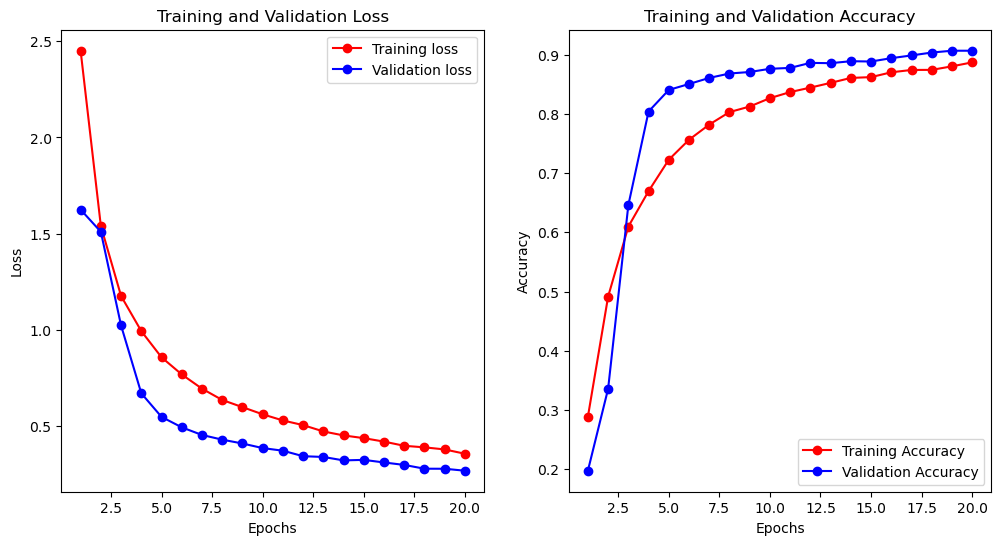

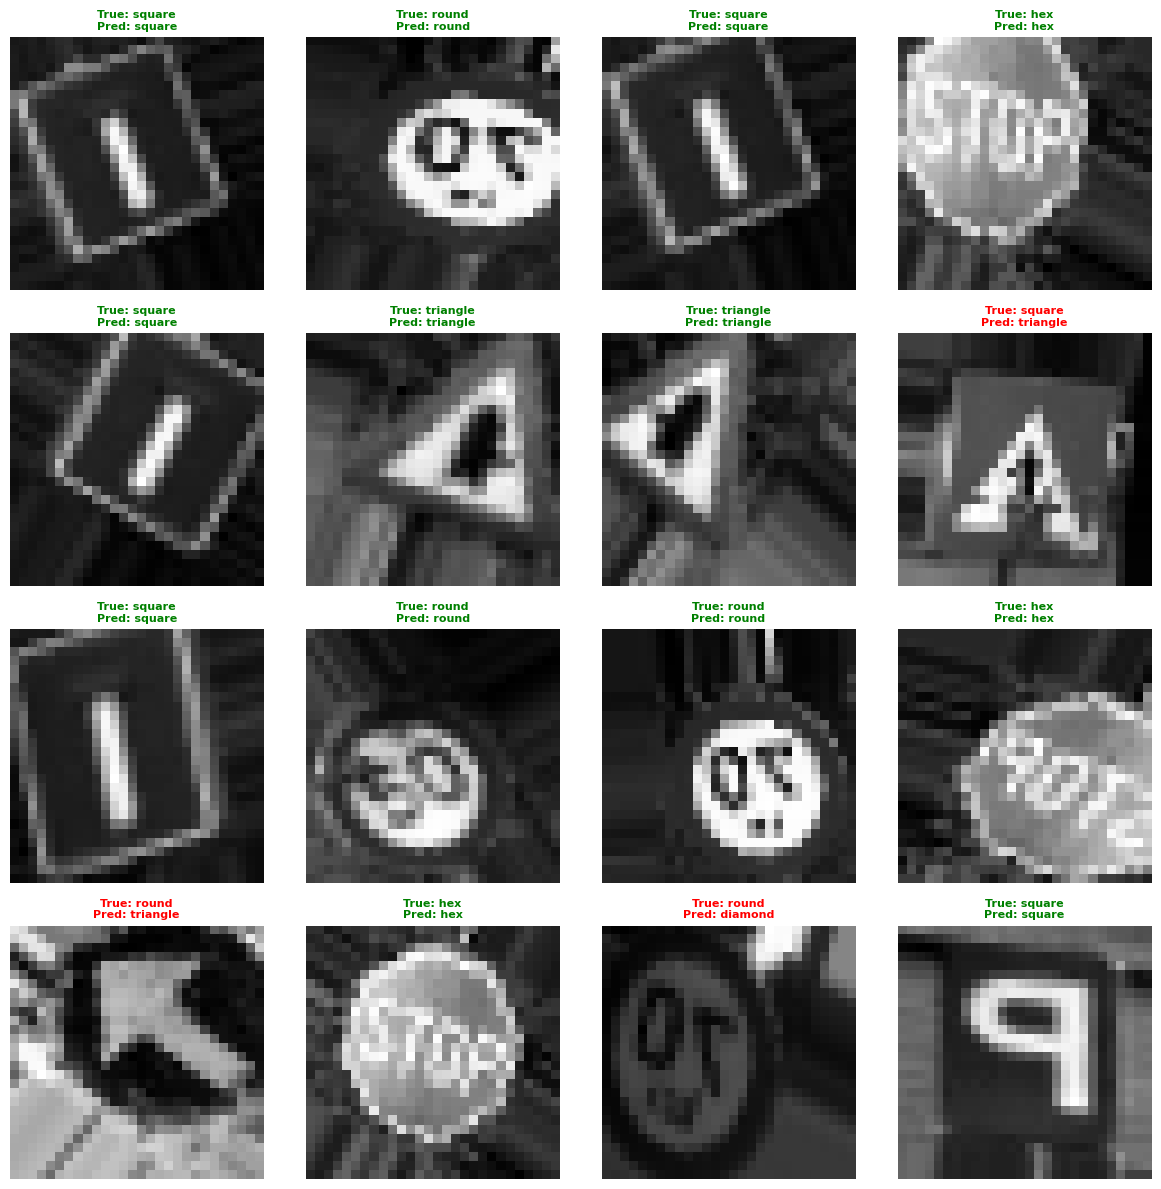

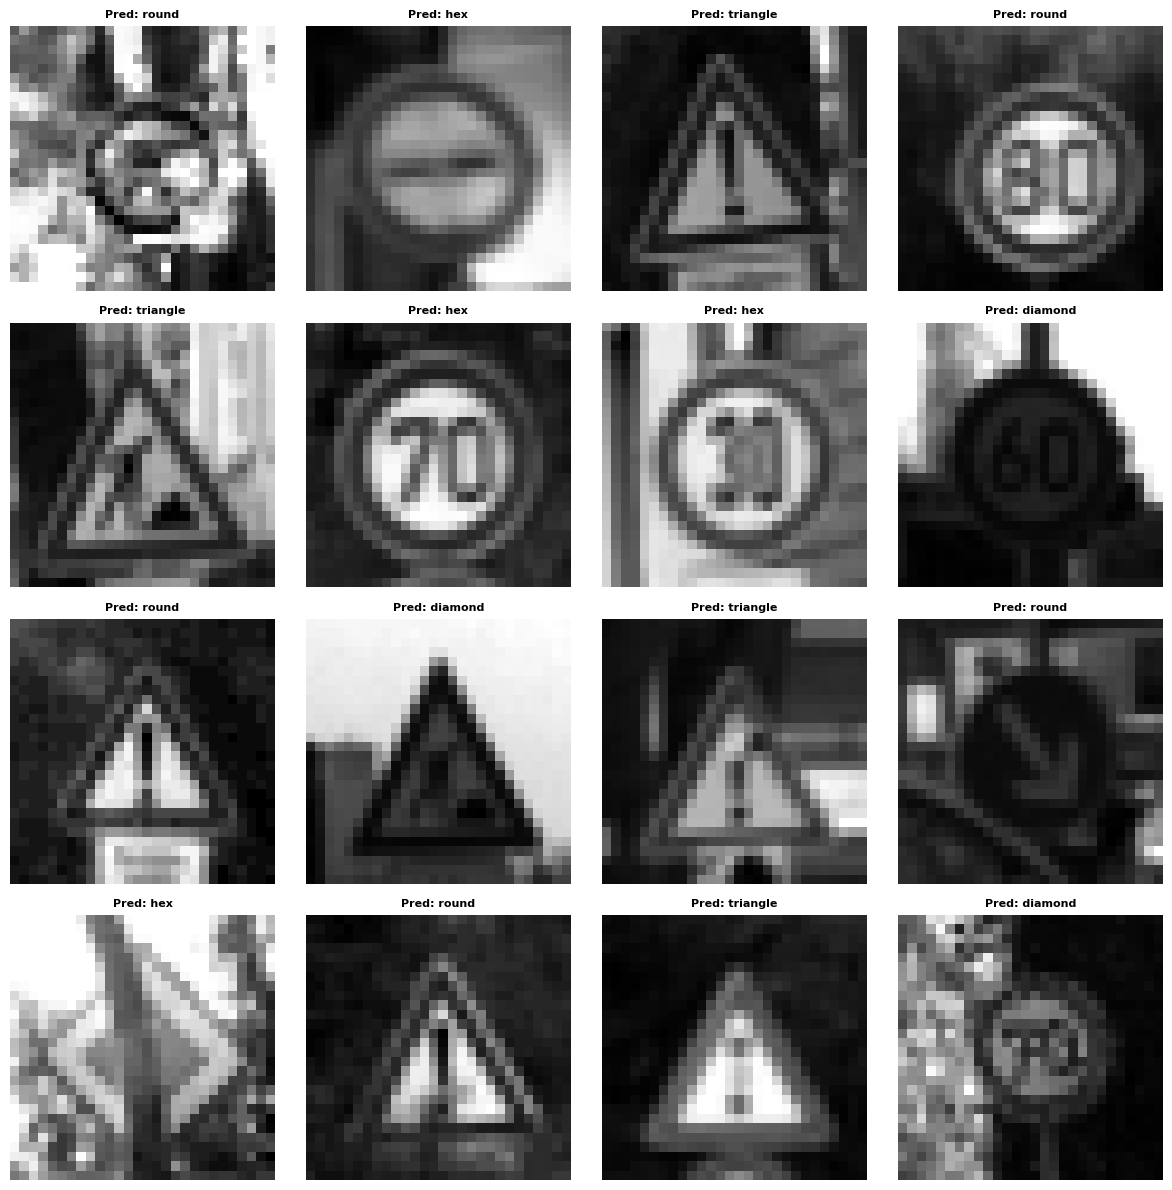

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 216)                 │         249,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          27,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 563,901 (2.15 MB)

 Trainable params: 563,901 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 1.6033 - sparse_categorical_accuracy: 0.2170 - val_loss: 1.5858 - val_sparse_categorical_accuracy: 0.1951
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 1.5753 - sparse_categorical_accuracy: 0.2257 - val_loss: 1.5502 - val_sparse_categorical_accuracy: 0.2015
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 1.5360 - sparse_categorical_accuracy: 0.2441 - val_loss: 1.4872 - val_sparse_categorical_accuracy: 0.3041
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 1.4755 - sparse_categorical_accuracy: 0.3525 - val_loss: 1.3800 - val_sparse_categorical_accuracy: 0.4826
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 1.3603 - sparse_categorical_accuracy: 0.4994 - val_loss: 1.2190 - val_sparse_categorical_accuracy: 0.6872
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.5999 - val_loss: 1.0205 - val_sparse_categorical_accuracy:

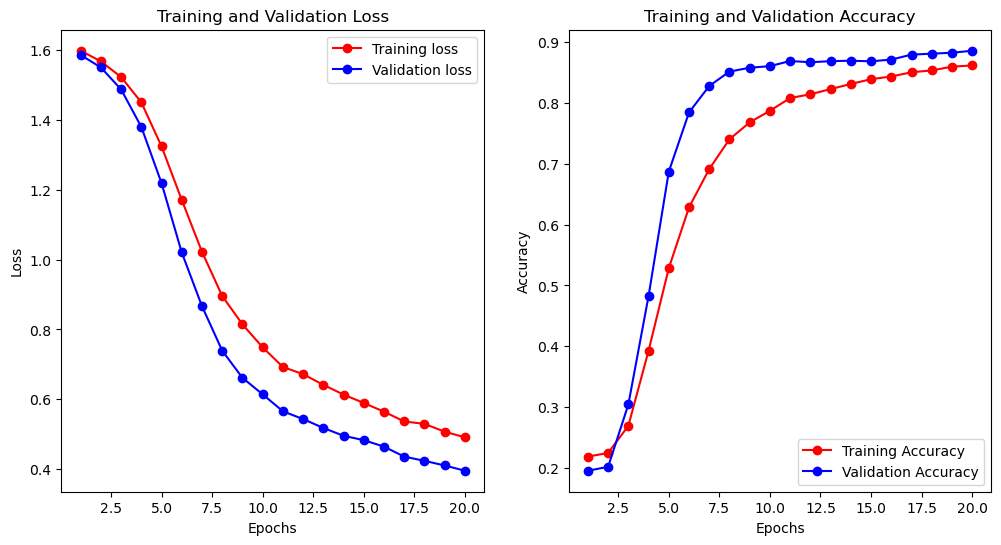

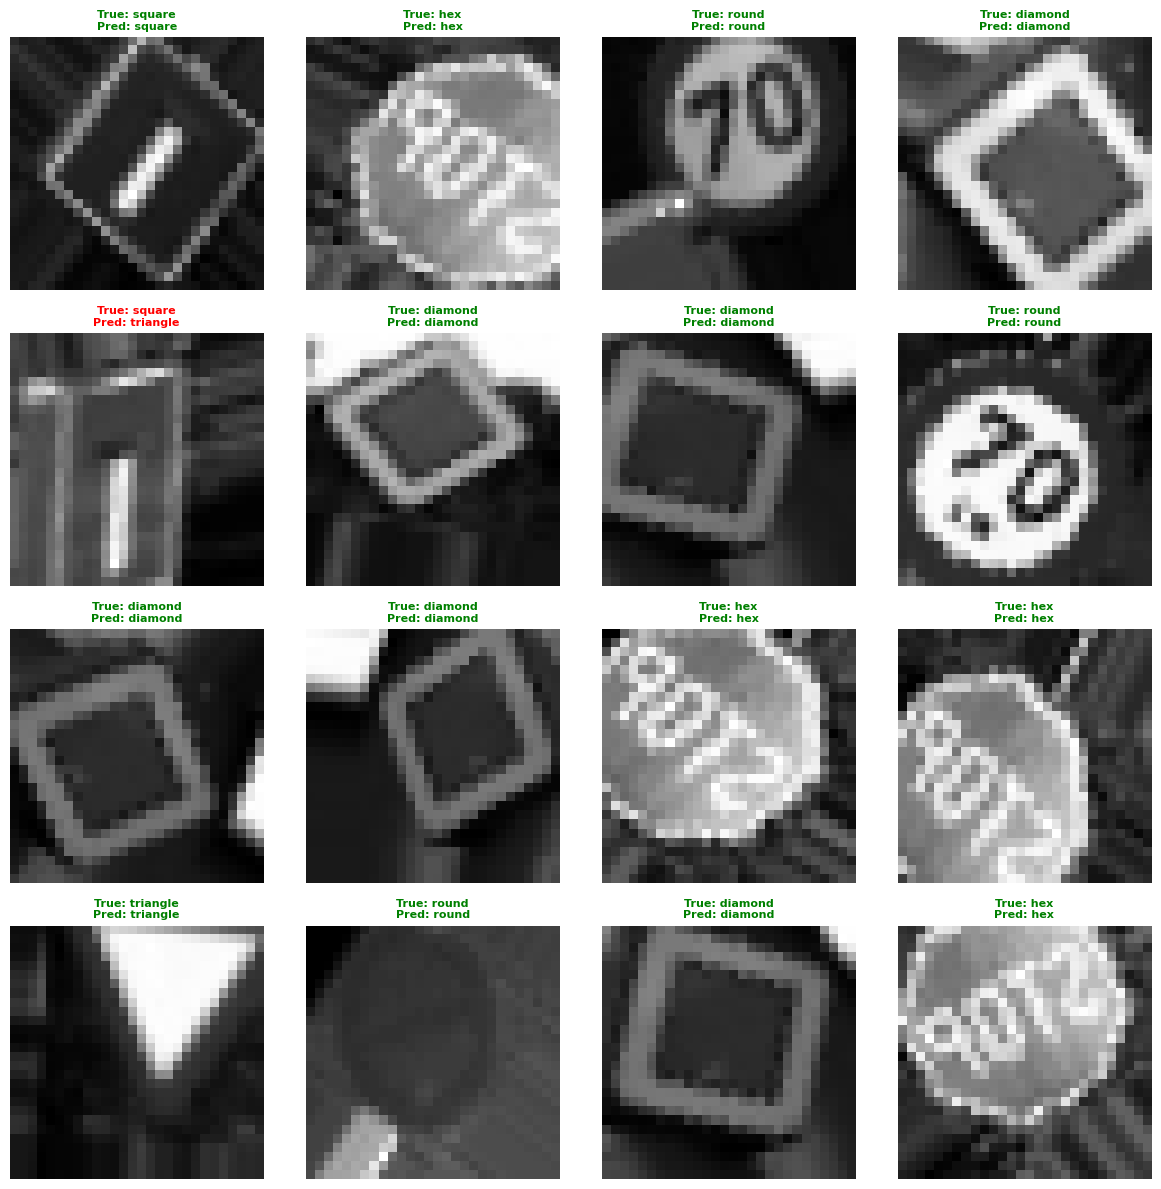

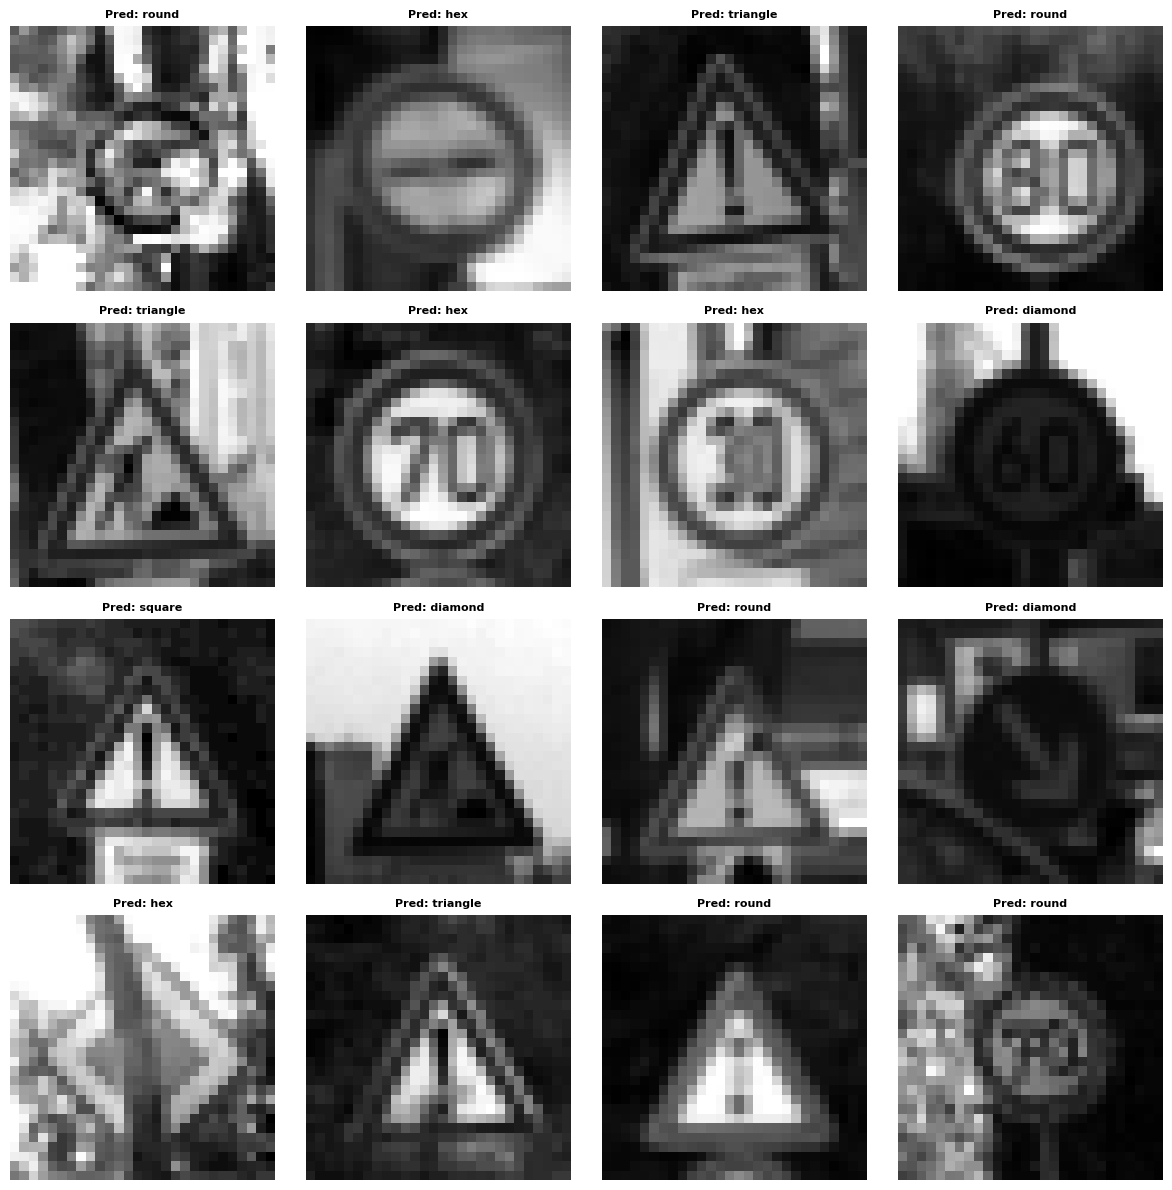

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 216)                 │         249,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          27,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 564,797 (2.15 MB)

 Trainable params: 564,349 (2.15 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 2.1736 - sparse_categorical_accuracy: 0.2923 - val_loss: 1.6248 - val_sparse_categorical_accuracy: 0.2023
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 1.0003 - sparse_categorical_accuracy: 0.6319 - val_loss: 1.5993 - val_sparse_categorical_accuracy: 0.2285
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.7663 - val_loss: 1.2930 - val_sparse_categorical_accuracy: 0.4985
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.5631 - sparse_categorical_accuracy: 0.8190 - val_loss: 0.6340 - val_sparse_categorical_accuracy: 0.8249
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 0.4790 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.8849
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 0.4244 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.2935 - val_sparse_categorical_accuracy:

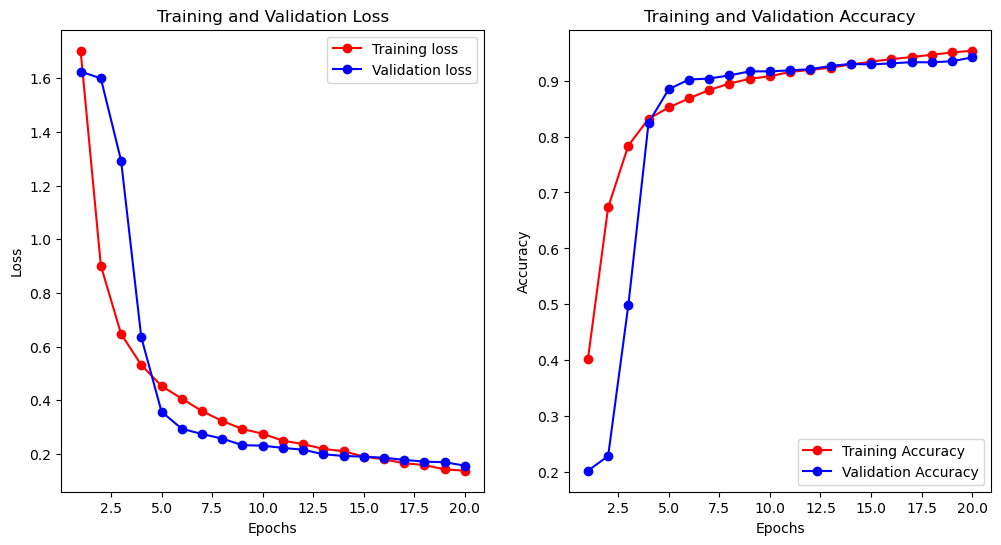

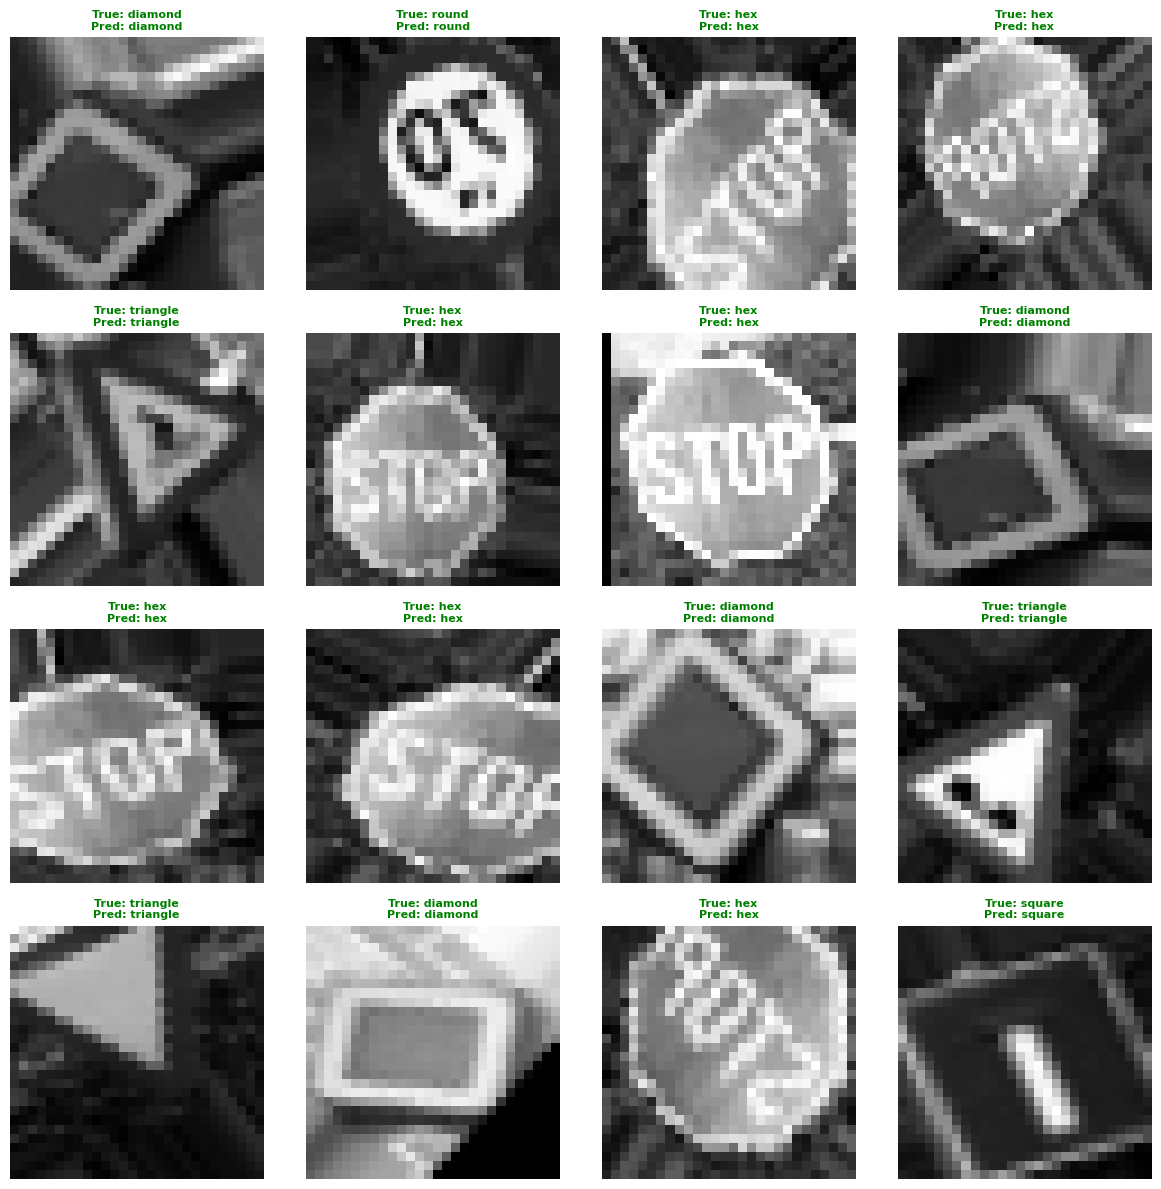

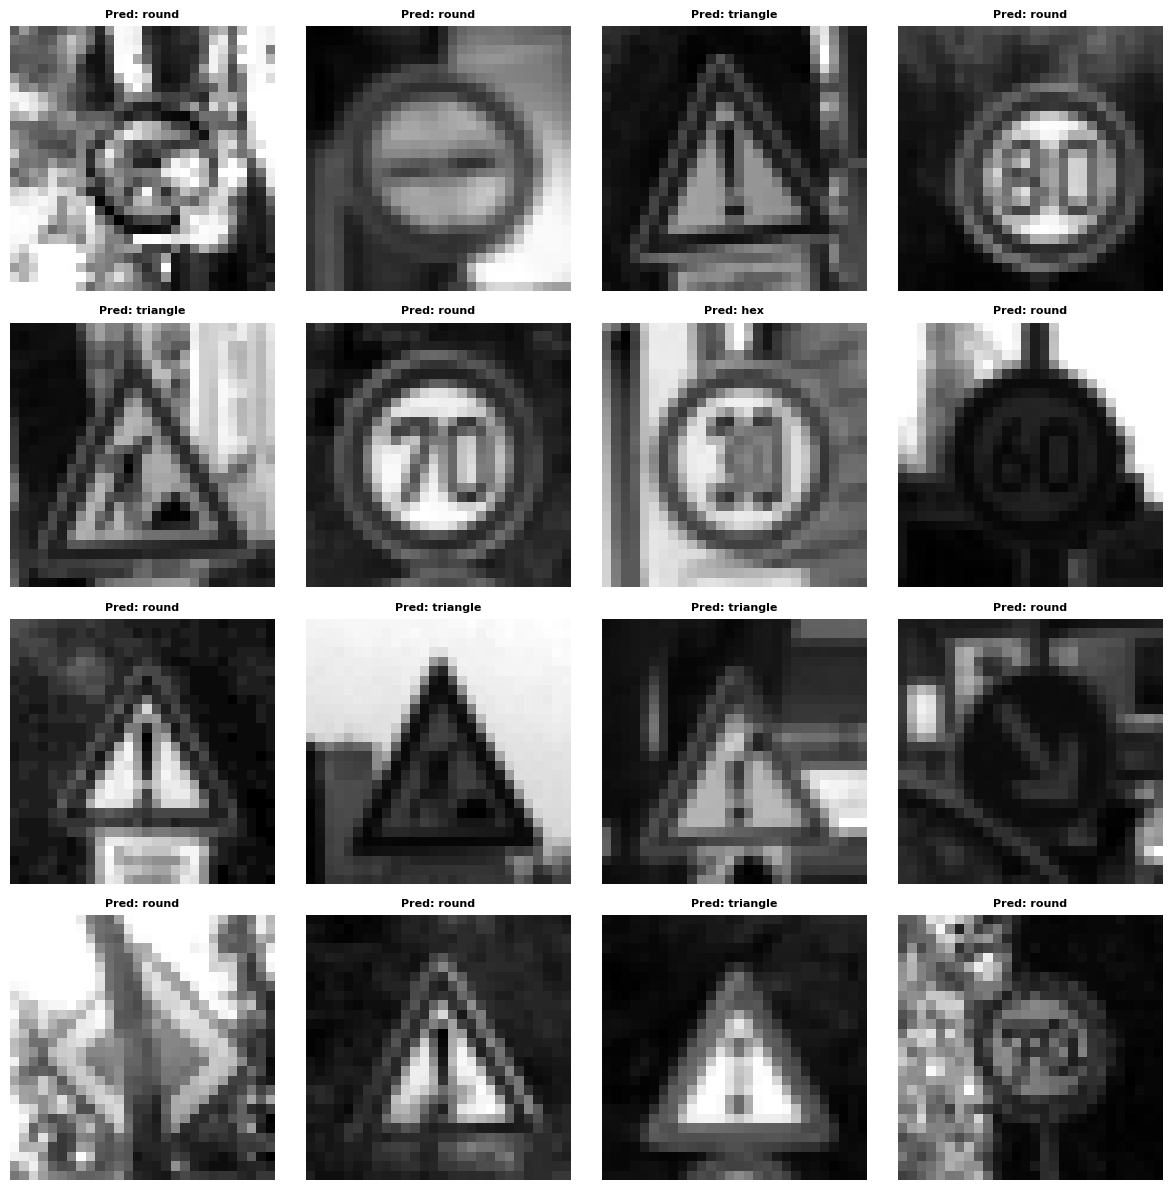

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 16)          │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 28, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,139,013 (4.34 MB)

 Trainable params: 1,139,013 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - loss: 1.5942 - sparse_categorical_accuracy: 0.2320 - val_loss: 1.5194 - val_sparse_categorical_accuracy: 0.2813
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - loss: 1.4629 - sparse_categorical_accuracy: 0.3711 - val_loss: 1.2576 - val_sparse_categorical_accuracy: 0.5892
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - loss: 1.1807 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.9591 - val_sparse_categorical_accuracy: 0.7790
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - loss: 0.9053 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.7319 - val_sparse_categorical_accuracy: 0.8149
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - loss: 0.7196 - sparse_categorical_accuracy: 0.8198 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.8444
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - loss: 0.6147 - sparse_categorical_accuracy: 0.8442 - val_loss: 0.5489 - val_sparse_categorical_acc

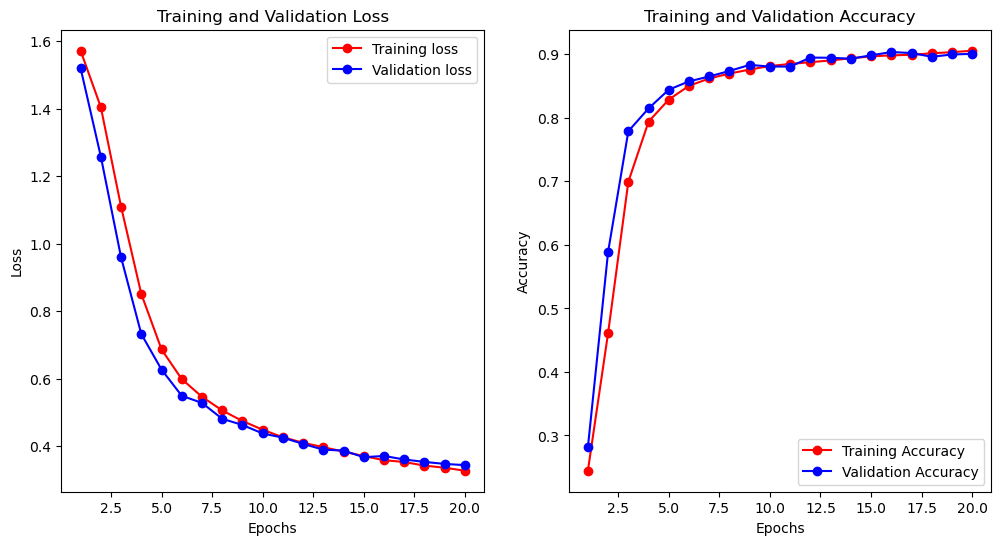

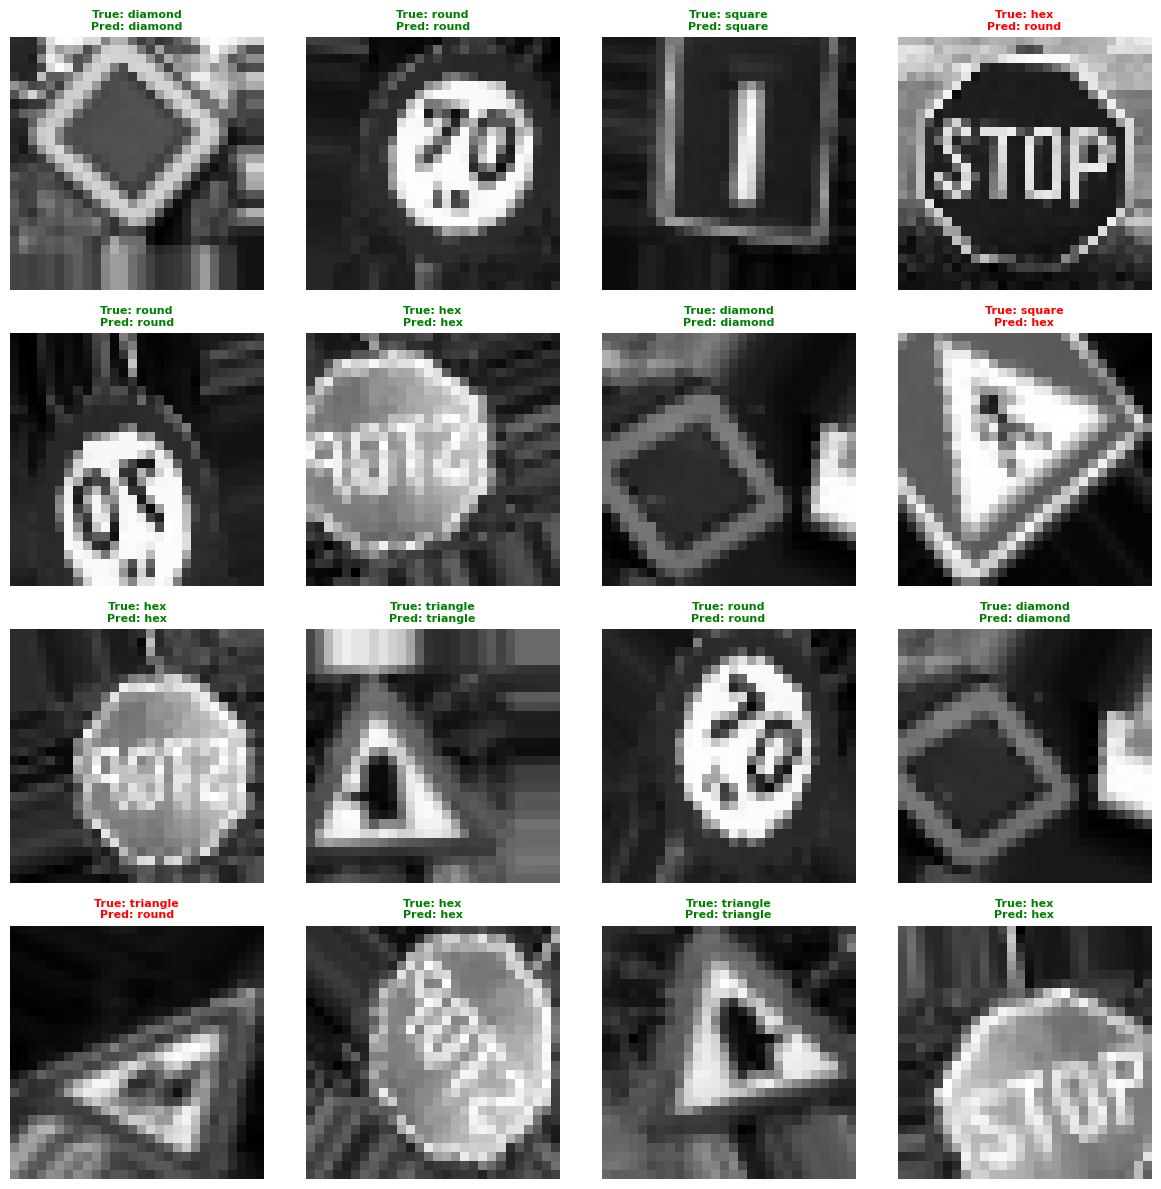

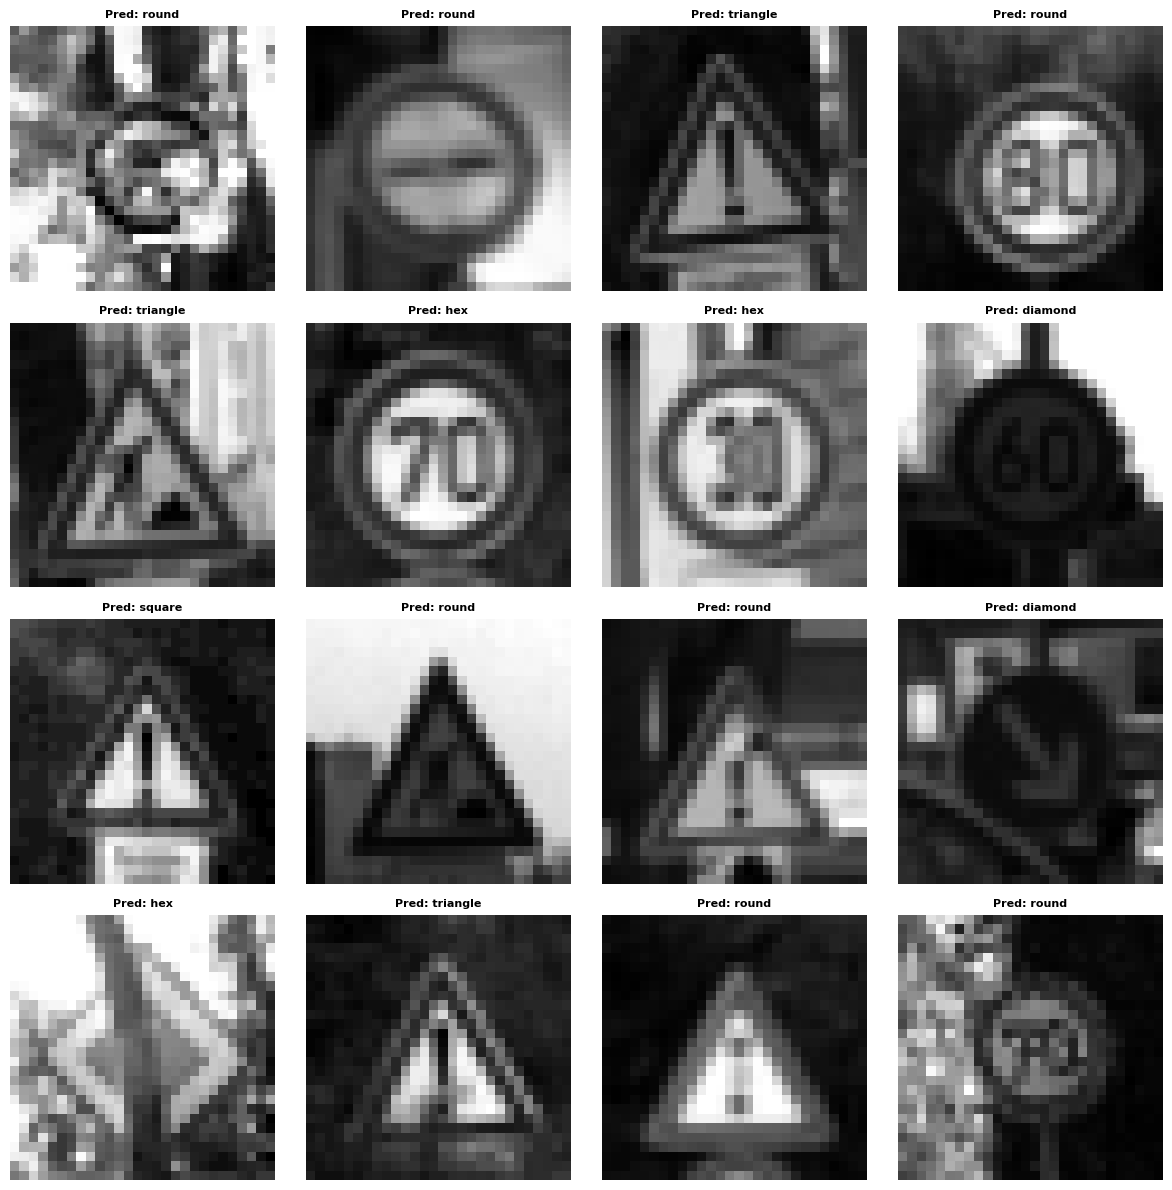

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 28, 28, 16)          │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,139,525 (4.35 MB)

 Trainable params: 1,139,269 (4.35 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - loss: 1.3403 - sparse_categorical_accuracy: 0.5271 - val_loss: 1.5868 - val_sparse_categorical_accuracy: 0.2046
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - loss: 0.4421 - sparse_categorical_accuracy: 0.8661 - val_loss: 1.5409 - val_sparse_categorical_accuracy: 0.3197
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - loss: 0.3041 - sparse_categorical_accuracy: 0.9052 - val_loss: 1.2793 - val_sparse_categorical_accuracy: 0.6051
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - loss: 0.2328 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.8408
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.2702 - val_sparse_categorical_accuracy: 0.9228
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - loss: 0.1570 - sparse_categorical_accuracy: 0.9480 - val_loss: 0.1972 - val_sparse_categorical_acc

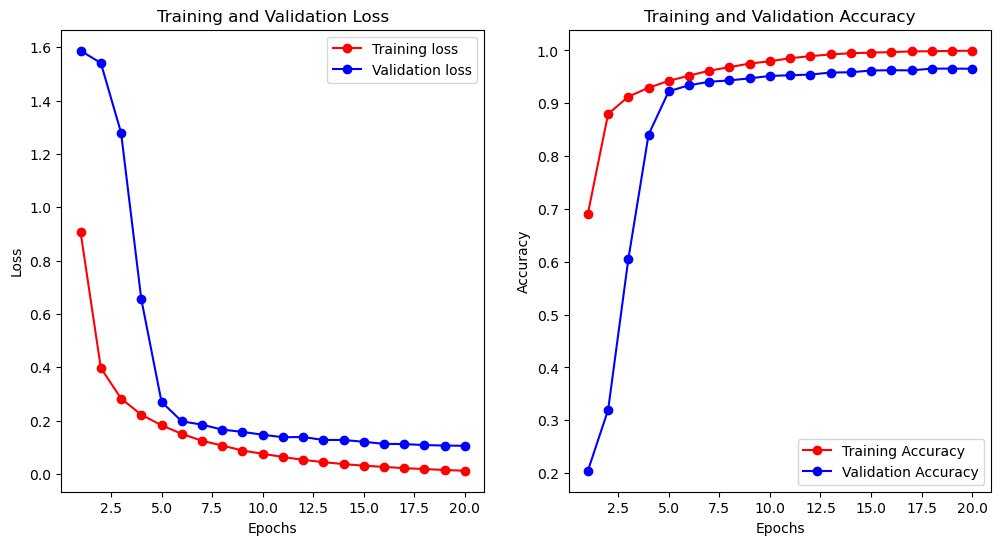

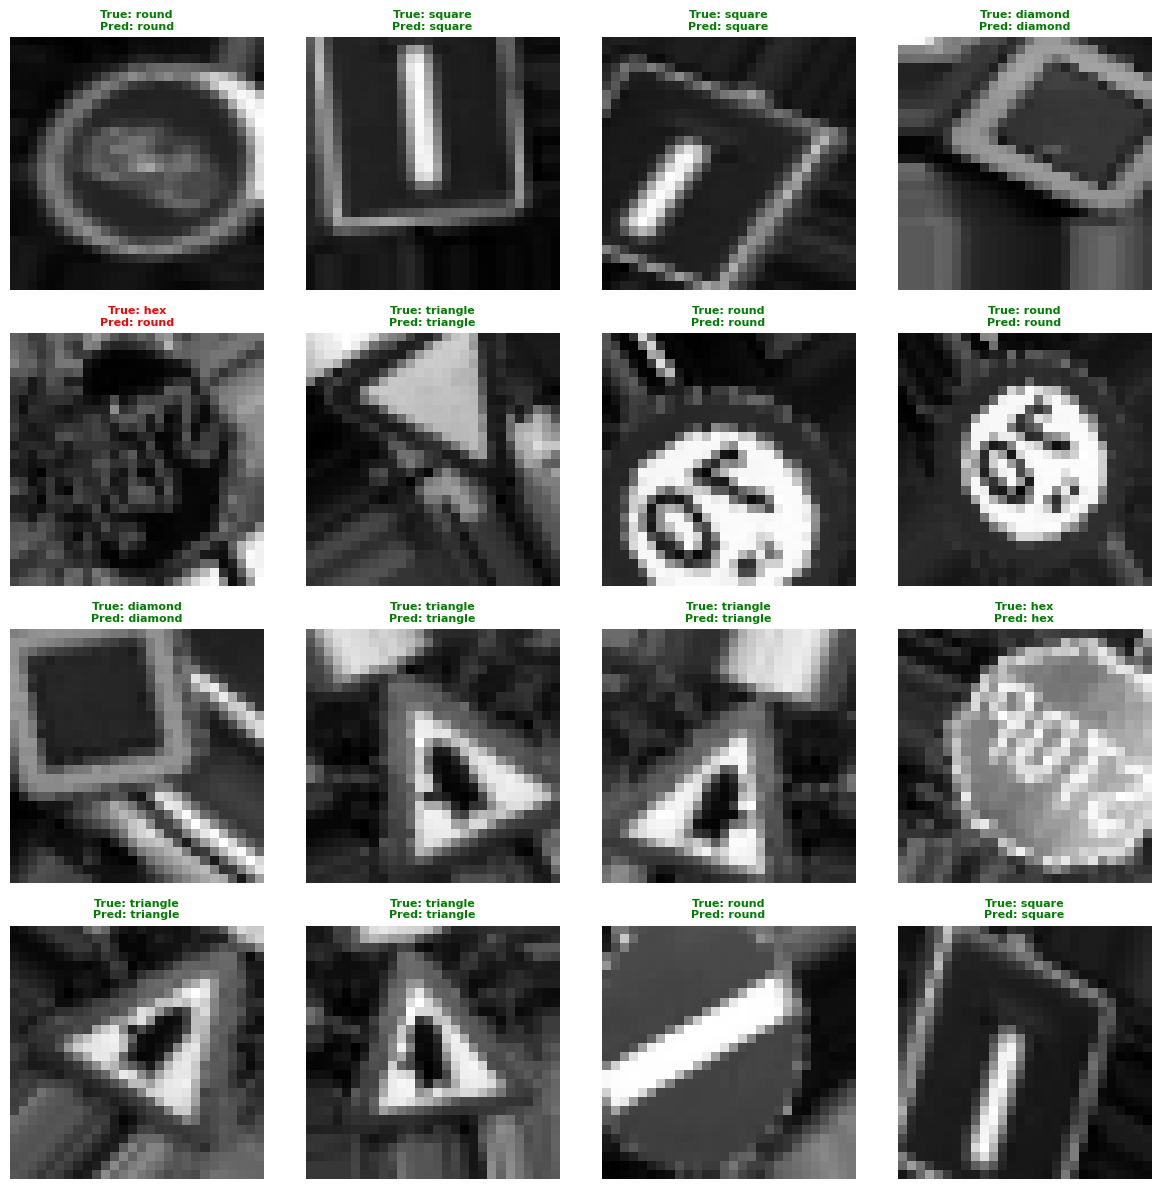

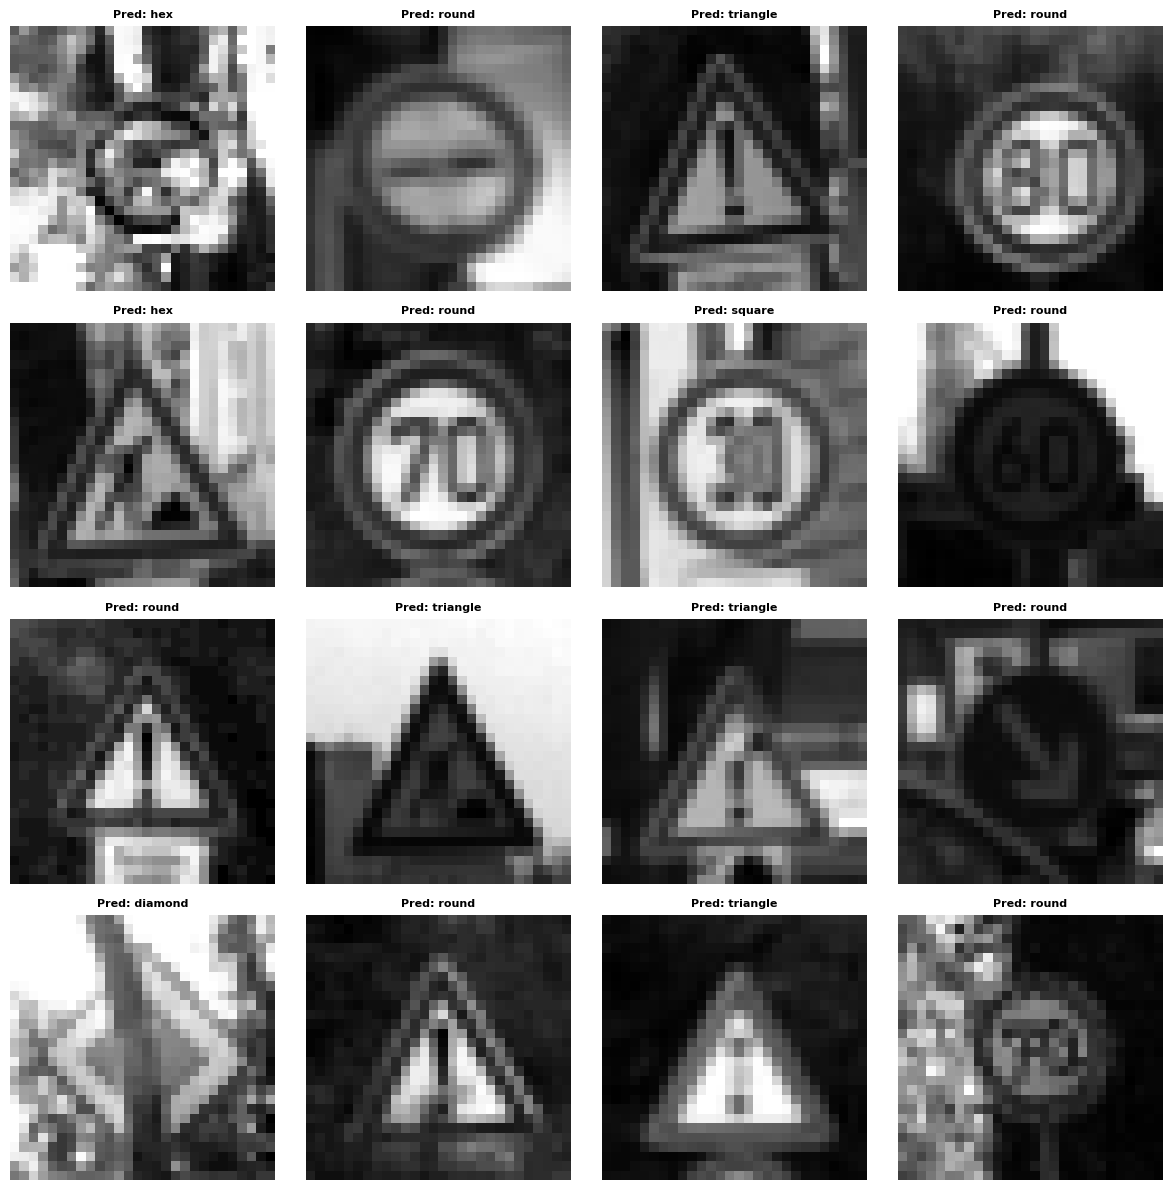

In [9]:
# Iterate through each model
for target_model in NeuralNetwork_models:
    target_model.compile(
        optimizer=RMSprop(learning_rate=1e-6, momentum=0.9),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

    target_model.summary()

    hist = target_model.fit(
        train,
        epochs=20,
        batch_size=200,
        validation_data=val
    )

    # Plot the learning curve
    plot_learning_curve(hist)

    # Evaluate the model
    vResults_tf(target_model, val, data.class_names)
    vResults_raw(target_model, raw_data, data.class_names)